In [1]:
import pymolpro as pmp
import math 
import numpy as np


def orbitalsize(orbital):
    return math.sqrt(sum([orbital.local_second_moments[i][i] for i in range(3)]))**3

def chkorbid(o1,o2):
    if o1.startswith('-'):
        chko1=o1[1:]
    else:
        chko1=o1
    if o2.startswith('-'):
        chko2=o2[1:]
    else:
        chko2=o2
    if chko1==chko2:
        return True
    else: 
        return False

In [2]:
geo_list=['He','Ne','Ar','Kr']
p_list=[]

In [3]:
for i in geo_list:
    p=pmp.Project(i)
    p.write_input(f"""
    geometry={{{i}}}
    rhf;
    locali, pipek;
    {{MP2;core, 0}}
    put,xml
    """
                  )
    p.run(wait=True)
    p_list.append(p)
    print(i, "done")

He done
Ne done
Ar done
Kr done


In [51]:
pair_list=[]
test_dens_list=[]
train_arr_list=[]
arr_list=[]
test_arr_list=[]
test_corr_list=[]
for p in p_list:
    orbital_dt={}
    dens_dt={}
    if p.name=='Ar':
        for orbital in p.orbitals():
            orbital_dt.update({orbital.ID:{
                'e':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
                's':float(orbitalsize(orbital))}})
            orbital_dt.update({f'-{orbital.ID}':{
                'e':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
                's':float(orbitalsize(orbital))}})
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            values=values**2
            values=np.append(orbitalsize(orbital),values)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([orbital_dt[oid1]['s']])
                test_dens_list.append(dens_dt[oid1])
                test_arr_list.append(tmp_arr)
                test_corr_list.append(float(tmp['energy']))

    else:
        for orbital in p.orbitals():
            orbital_dt.update({orbital.ID:{
                'e':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
                's':float(orbitalsize(orbital))}})
            orbital_dt.update({f'-{orbital.ID}':{
                'e':float(p.xpath("//orbitals/orbital[@ID='"+orbital.ID+"']/@energy")[0]),
                's':float(orbitalsize(orbital))}})
            points=orbital.grid(4)
            values=orbital.evaluate(points,values=True)
            values=values**2
            values=np.append(orbitalsize(orbital),values)
            dens_dt.update({f'{orbital.ID}':values})
            dens_dt.update({f'-{orbital.ID}':values})
        for pair in p.xpath("//pair"):
            tmp=pmp.element_to_dict(pair)
            oid1,oid2=tmp['orbital1'],tmp['orbital2']
            if chkorbid(oid1,oid2)==True:
                tmp_arr=np.array([orbital_dt[oid1]['s']])
                train_arr_list.append(dens_dt[oid1])
                arr_list.append(tmp_arr)
                pair_list.append(float(tmp['energy']))
                    
labels=np.array(pair_list)
features=np.stack(train_arr_list)
arr_list=np.stack(arr_list)

In [ ]:
features.shape


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - loss: 0.0019 - mae: 0.0211 - mape: 6096549.0000
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 727us/step - loss: 0.0016 - mae: 0.0276 - mape: 2831328.5000
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 0.0015 - mae: 0.0212 - mape: 2158610.2500
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - loss: 7.8919e-04 - mae: 0.0148 - mape: 6436281.0000
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 7.6596e-04 - mae: 0.0170 - mape: 3018260.7500
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 3.4190e-04 - mae: 0.0113 - mape: 1712997.6250
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 642us/step - loss: 1.3482e-04 - mae: 0.0074 - mape: 713904.8750
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step - loss: 9.9290e-06 - mae: 0.0025 - mape: 129720.8516
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 1.3130e-05 - mae: 0.0028 - mape: 76366.0156
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step

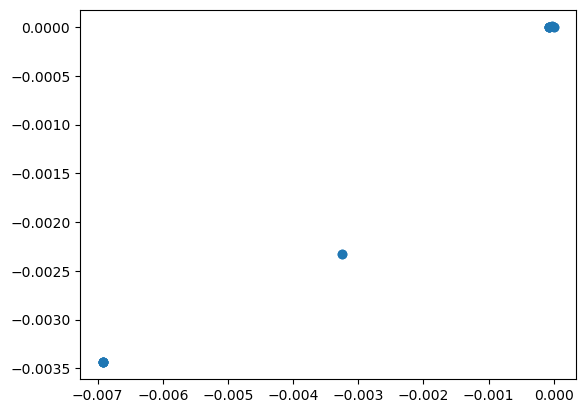

In [52]:
import keras
import tensorflow as tf

dataset=tf.data.Dataset.from_tensor_slices((features,labels))
dataset = dataset.shuffle(buffer_size=len(pair_list)//4).batch(batch_size=1)


model=keras.Sequential([
    keras.layers.Input(shape=(65,)),
    keras.layers.Dense(500, activation='softmax'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam',
              loss='mse',
             metrics=['mae','mape'])
model.fit(dataset,epochs=100)
test_arr=np.stack(test_dens_list)
predictions=model.predict(test_arr)

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.scatter(test_corr_list,predictions)


In [37]:
print(predictions)

[[-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.00118912]
 [-0.00118912]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.00118912]
 [-0.00118912]
 [-0.0003837 ]
 [-0.0003837 ]
 [-0.00118912]
 [-0.00118912]]


In [10]:
print(test_arr_list)

[array([0.00011847]), array([0.00011847]), array([0.00838647]), array([0.00838647]), array([0.19081488]), array([0.19081488]), array([0.22889207]), array([0.22889207]), array([0.22889207]), array([0.22889207]), array([5.27055299]), array([5.27055299]), array([0.00572435]), array([0.00572435]), array([0.20112477]), array([0.20112477]), array([9.17677396]), array([9.17677396]), array([0.00572435]), array([0.00572435]), array([0.20112477]), array([0.20112477]), array([9.17677396]), array([9.17677396]), array([0.22889207]), array([0.22889207]), array([0.00572435]), array([0.00572435]), array([0.20112477]), array([0.20112477]), array([9.17677396]), array([9.17677396]), array([0.22889207]), array([0.22889207]), array([0.22889207]), array([0.22889207])]


In [48]:
import tensorflow as tf
import keras


def build_nn1(input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(5, activation='relu')
    ])
    return model


def build_nn2(combined_input_shape):
    model = keras.Sequential([
        keras.layers.Input(shape=combined_input_shape),
        keras.layers.Dense(20, activation='relu'),
        keras.layers.Dense(1) 
    ])
    return model


input_shape_nn1 = (64,)
input_shape_nn2 = (6,)
nn1 = build_nn1(input_shape_nn1)
nn2 = build_nn2(input_shape_nn2)


optimizer = tf.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.losses.MeanSquaredError()



for epoch in range(100):
    with tf.GradientTape() as tape:
    
        intermediate_output = nn1(features)

        combined_input = tf.concat([intermediate_output, arr_list], axis=-1)

        output = nn2(combined_input)
        
        loss = tf.loss_fn(labels, output)
    

    gradients = tape.gradient(loss, nn1.trainable_variables + nn2.trainable_variables)
    
    keras.optimizer.apply_gradients(zip(gradients, nn1.trainable_variables + nn2.trainable_variables))
    
    print(f'Epoch {epoch+1}, Loss: {loss.numpy()}')

print("Training complete.")


AttributeError: module 'tensorflow' has no attribute 'loss_fn'